# Test méthode classique de débruitage

## Tansformée de Fourrier

In [229]:
# Import des modules
import os
import random
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import ndimage
from scipy import fftpack

In [230]:
# Bloc de fonctions utiles 

# Importer une image
def import_image(filename):
    image = ski.io.imread(filename)
    return np.array(image)

# Affichage histogramme d'une image
def display_histogram(image):
    plt.figure()
    plt.hist(image.flatten(), bins=256, range=(0,256), density=True, color='black', alpha=0.75)
    plt.title('Histogramme')
    plt.xlabel('Valeurs des pixels')
    plt.ylabel('Fréquence')
    plt.show()


# Importer une image en niveaux de gris
def display_image(image,title):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def psnr(original_image, processed_image):
    # Convertir les images en float pour éviter les problèmes d'arrondi
    original_image = original_image.astype(np.float64)
    processed_image = processed_image.astype(np.float64)
    
    # Calculer la MSE (Mean Squared Error)
    mse = np.mean((original_image - processed_image) ** 2)
    
    # Si la MSE est nulle, les deux images sont identiques
    if mse == 0:
        return float('inf')
    
    # Calculer le PSNR
    max_pixel = 255.0  # Valeur maximale des pixels pour une image 8 bits
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    
    return psnr


In [231]:
# Bloc de fonctions pour le débruitage

def apply_fourier_transform(image):
    fourier = np.fft.fft2(image)
    fourier_shifted = np.fft.fftshift(fourier)
    return fourier_shifted

def display_fourier_transform(fourier_shifted, title):
    # Calculer la magnitude de la transformée de Fourier
    magnitude_spectrum = np.abs(fourier_shifted)
    # Appliquer une échelle logarithmique pour une meilleure visualisation
    magnitude_spectrum = np.log(magnitude_spectrum + 1)
    
    # Affichage de la magnitude de la transformée de Fourier
    plt.figure()
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def apply_inverse_fourier_transform(filtered_fourier):
    filtered_fourier_shifted_back = np.fft.ifftshift(filtered_fourier)
    denoised_image = np.fft.ifft2(filtered_fourier_shifted_back)
    denoised_image = np.abs(denoised_image)  # Prendre l'amplitude réelle
    return denoised_image

def apply_low_pass_filter(fourier_shifted, radius):
    # dimensions de l'image dans le domaine fréquentiel
    rows, cols = fourier_shifted.shape
    
    # centre de l'image en fréquence (basses fréquences)
    center_row, center_col = rows // 2, cols // 2
    
    # masque représentant la suppression de fréquence
    mask = np.zeros((rows, cols), dtype=np.uint8)
    
    # parcourir chaque pixel pour créer un cercle autour du centre
    for i in range(rows):
        for j in range(cols):
            # distance au carré du pixel (i, j) par rapport au centre
            # si distance est inférieure ou égale au rayon^2, le pixel est dans les basses fréquences
            if (i - center_row)**2 + (j - center_col)**2 <= radius**2:
                # assigner une valeur de 1 dans le masque pour conserver cette fréquence
                mask[i, j] = 1
    
    # Appliquer le masque
    filtered_fourier = fourier_shifted * mask
    
    # Retourner la transformée de Fourier contenant uniquement les basses fréquences
    return filtered_fourier

def apply_gaussian_low_pass_filter(fourier_shifted, sigma):
    # dimensions de l'image dans le domaine fréquentiel
    rows, cols = fourier_shifted.shape

    # centre de l'image en fréquence (basses fréquences)
    center_row, center_col = rows // 2, cols // 2

    # filtre gaussien basé sur la distance au centre
    mask = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            distance = ((i - center_row) ** 2 + (j - center_col) ** 2)
            mask[i, j] = np.exp(-distance / (2 * sigma ** 2))
    
    # Appliquer le masque
    filtered_fourier = fourier_shifted * mask

    # Retourner la transformée de Fourier contenant uniquement les basses fréquences
    return filtered_fourier



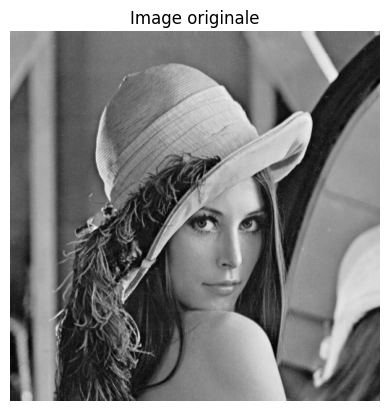

In [232]:
# Bloc de test d'affichage de l'image et de son histogramme

# Importer l'image
image = import_image('lena.pgm')
display_image(image,'Image originale')
# display_histogram(image)


In [233]:
# Test PSNR de deux images identiques
image1 = import_image('lena.pgm')
image2 = import_image('lena.pgm')
psnr_value = psnr(image1, image2)
print('PSNR entre deux images identiques :', psnr_value)

PSNR entre deux images identiques : inf


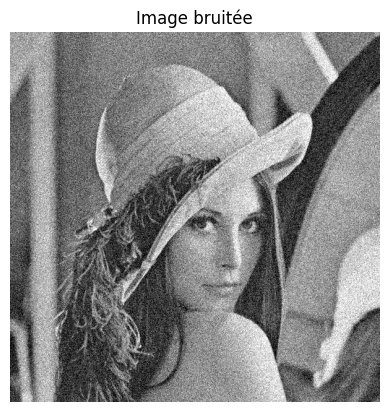

In [234]:
# Ajout de bruit à l'image
image_noised = ski.util.random_noise(image, mean=0, var=0.01)
display_image(image_noised,'Image bruitée')

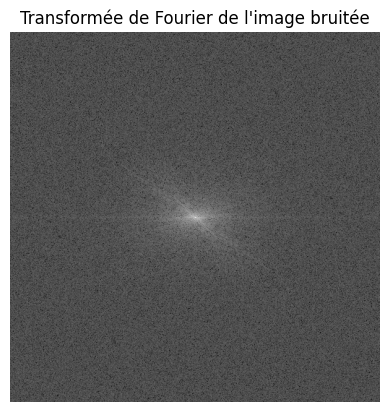

In [235]:
# Bloc de test d'affichage de la transformée de Fourier
image_fourier = image_noised.copy()

# Appliquer la transformée de Fourier
image_fourier = apply_fourier_transform(image_fourier)
display_fourier_transform(image_fourier, 'Transformée de Fourier de l\'image bruitée')

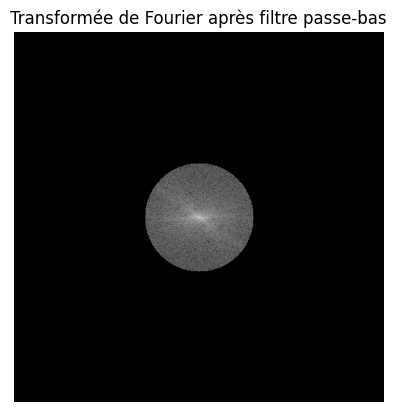

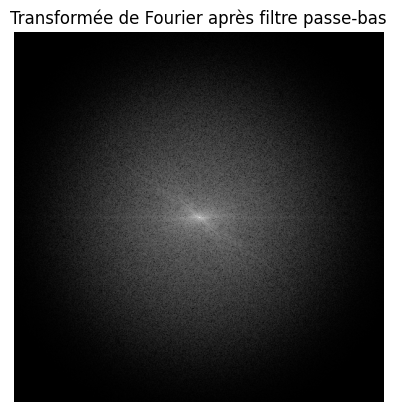

In [236]:
# Bloc de test pour appliquer un filtre passe-bas sur une transformée de Fourier

image_low_pass_fourier = image_fourier.copy()
image_low_pass_gauss_fourier = image_fourier.copy()

# Appliquer le filtre passe-bas sur l'image (méthode 1 avec un filtre passe-bas circulaire)
radius = 75 # rayon du cercle pour les basses fréquences
image_low_pass_fourier = apply_low_pass_filter(image_low_pass_fourier, radius)

# Appliquer le filtre passe-bas sur l'image (méthode 1 avec un filtre passe-bas gaussien)
sigma = 60 # rayon du cercle pour les basses fréquences
image_low_pass_gauss_fourier = apply_gaussian_low_pass_filter(image_low_pass_gauss_fourier, radius)

# Afficher la transformée de Fourier pour voir la différence (méthode 1)
display_fourier_transform(image_low_pass_fourier, 'Transformée de Fourier après filtre passe-bas')

# Appliquer la transformée de Fourier pour voir la différence (méthode 2)
display_fourier_transform(image_low_pass_gauss_fourier, 'Transformée de Fourier après filtre passe-bas gaussien')

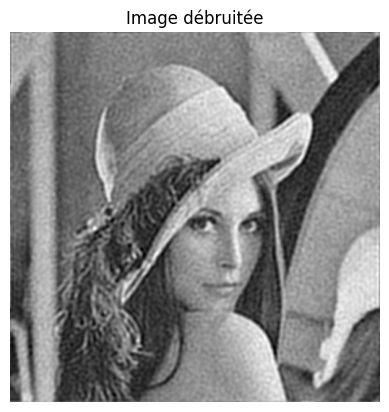

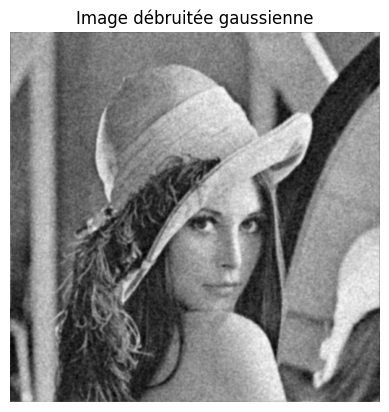

In [237]:
# Appliquer une transformée de Fourier inverse
denoised_image = image_low_pass_fourier.copy()
denoised_image = apply_inverse_fourier_transform(denoised_image)

denoised_image_gauss = image_low_pass_gauss_fourier.copy()
denoised_image_gauss = apply_inverse_fourier_transform(denoised_image_gauss)

# Afficher l'image débruitée
display_image(denoised_image, 'Image débruitée')
display_image(denoised_image_gauss, 'Image débruitée gaussienne')

In [238]:
# Test PSNR entre l'image originale et l'image débruitée
psnr_value = psnr(image, denoised_image)
psnr_value_gauss = psnr(image, denoised_image_gauss)
print('PSNR entre l\'image originale et l\'image débruitée :', psnr_value)
print('PSNR entre l\'image originale et l\'image débruitée gaussienne :', psnr_value_gauss)

PSNR entre l'image originale et l'image débruitée : 5.37523324894477
PSNR entre l'image originale et l'image débruitée gaussienne : 5.375197111665964
